# AI/ML - Research - Computer Vision

### biblioteki


In [21]:
import kaggle
import os
import splitfolders 
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision     
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns



### podział danych

In [2]:
SEED = "HackYeah"
data_path = './data'
data_tmp = './data_tmp'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(data_path):
    print("Dane sa juz pobrane")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('gergvincze/simple-hand-drawn-and-digitized-images', path=data_tmp, unzip=True)
    splitfolders.ratio(input=data_tmp, move=True, output=data_path, seed=SEED, ratio=(0.7, 0.15, 0.15))
    shutil.rmtree(data_tmp)

Dane sa juz pobrane


In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_path, 'train'), transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)

val_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_path, 'val'), transform=transform
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True
)

test_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_path, 'test'), transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True
)

In [4]:
train_ds.classes


['anchor',
 'balloon',
 'bicycle',
 'envelope',
 'paper_boat',
 'peace_symbol',
 'smiley',
 'speech_bubble',
 'spiral',
 'thumb']

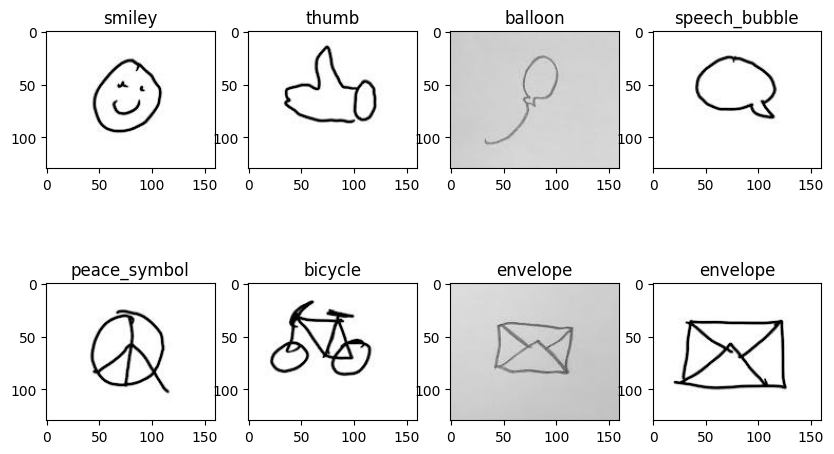

In [5]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for ax, img, lab in zip(axes, images, labels):
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(f"{train_ds.classes[lab.item()]}")
plt.show()

Problem moze tutaj byc z uwagi na to ze obrazki nie sa na jednolitym tle przez co CNN moze wykryc poszczegolne miejsca jako krawedzie, niektore obrazki są niewyraźne co również raczej wpłynie na finaly efekt uczenia 


In [6]:
def check_image_shapes(dataset):
    shapes = [img.shape for img, _ in dataset]
    common = max(set(shapes), key=shapes.count)
    diff = [i for i, s in enumerate(shapes) if s != common]
    print(f"Najczęstszy wymiar: {common}")
    print(f"Liczba różnych: {len(diff)}")
    return diff

diff_idx = check_image_shapes(train_ds)



Najczęstszy wymiar: torch.Size([3, 130, 160])
Liczba różnych: 0


wszystkie obrazki sa deafultowo tego samego rozmiaru 

In [7]:
pd.Series([label for _, label in train_ds]).map(lambda x: train_ds.classes[x]).value_counts()


anchor           30
balloon          30
bicycle          30
envelope         30
peace_symbol     30
smiley           30
spiral           30
thumb            30
paper_boat       29
speech_bubble    28
Name: count, dtype: int64

In [8]:
pd.Series([label for _, label in val_ds]).map(lambda x: val_ds.classes[x]).value_counts()


anchor           6
balloon          6
bicycle          6
envelope         6
paper_boat       6
peace_symbol     6
smiley           6
speech_bubble    6
spiral           6
thumb            6
Name: count, dtype: int64

In [9]:
pd.Series([label for _, label in test_ds]).map(lambda x: test_ds.classes[x]).value_counts()


anchor           8
bicycle          8
envelope         8
thumb            8
balloon          7
paper_boat       7
peace_symbol     7
smiley           7
speech_bubble    7
spiral           7
Name: count, dtype: int64

Trochę malutko danych 

powiekszenie roznorodnosci danych, aby sprobować znieść wpływ niejednorodnego tła 

In [10]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds.transform = train_transform

val_ds.transform = val_test_transform
test_ds.transform = val_test_transform

Nałożenie transformacji na obrazy

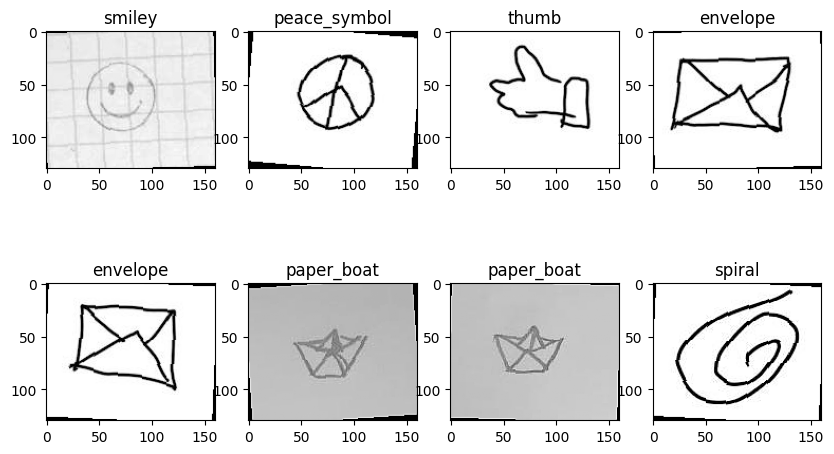

In [11]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for ax, img, lab in zip(axes, images, labels):
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)).mean(axis=2), cmap='gray')
    ax.set_title(f"{train_ds.classes[lab.item()]}")
plt.show()

In [12]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 20, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


num_classes = len(train_ds.classes)
model = MyCNN(num_classes)
model.apply(init_weights)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, eta_min=1e-6
)

Epoch 1/50 Train Loss: 8.5212, Train Acc: 0.2088, Val Loss: 4.3287, Val Acc: 0.1000
Zapisano nowy najlepszy model: 4.3287
Epoch 2/50 Train Loss: 4.0104, Train Acc: 0.4310, Val Loss: 4.2192, Val Acc: 0.1500
Zapisano nowy najlepszy model: 4.2192
Epoch 3/50 Train Loss: 3.2344, Train Acc: 0.4848, Val Loss: 3.4187, Val Acc: 0.2333
Zapisano nowy najlepszy model: 3.4187
Epoch 4/50 Train Loss: 2.4937, Train Acc: 0.5825, Val Loss: 2.9973, Val Acc: 0.2833
Zapisano nowy najlepszy model: 2.9973
Epoch 5/50 Train Loss: 1.8197, Train Acc: 0.6532, Val Loss: 1.8753, Val Acc: 0.4333
Zapisano nowy najlepszy model: 1.8753
Epoch 6/50 Train Loss: 2.1287, Train Acc: 0.6263, Val Loss: 1.1917, Val Acc: 0.6500
Zapisano nowy najlepszy model: 1.1917
Epoch 7/50 Train Loss: 1.6369, Train Acc: 0.6667, Val Loss: 0.9547, Val Acc: 0.7333
Zapisano nowy najlepszy model: 0.9547
Epoch 8/50 Train Loss: 1.4341, Train Acc: 0.6734, Val Loss: 0.9972, Val Acc: 0.7167
Epoch 9/50 Train Loss: 1.3238, Train Acc: 0.7037, Val Loss: 0.

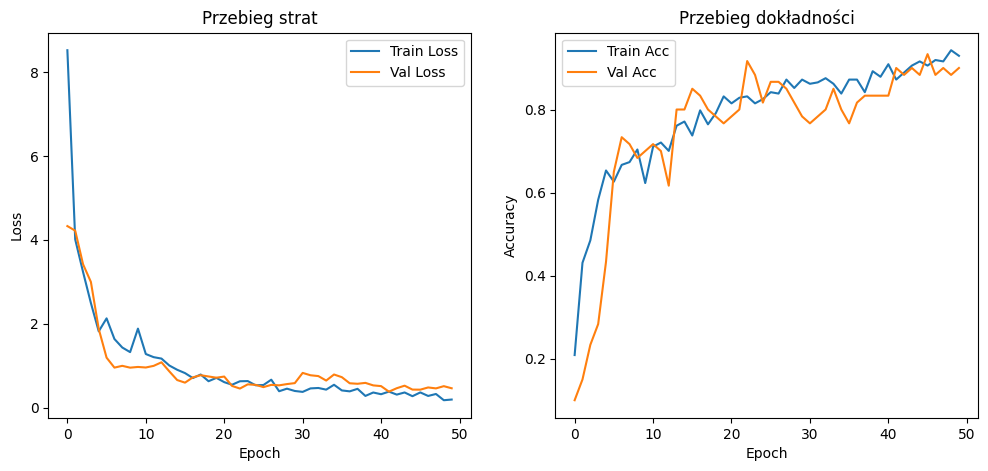

In [14]:
EPOCHS = 50
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists('NajlepszyPytroch.pth'):
    model.load_state_dict(torch.load('NajlepszyPytroch.pth'))
    print("Wczytano zapisany model")
else:
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_acc)
        
        scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS} "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'NajlepszyPytroch.pth')
            print(f"Zapisano nowy najlepszy model: {val_loss:.4f}")

model.load_state_dict(torch.load('NajlepszyPytroch.pth'))
print(f"najlepszy model: {best_val_loss:.4f}")

plt.figure(figsize=(12,5))

# loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Przebieg strat')
plt.legend()

# acc
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Przebieg dokładności')
plt.legend()

plt.show()

I po 3 h siedzenia nad tym okazuje się że nie umiem w matemaatykę i warstwę Linear źle przeliczałem, Pozdrawiam ❤️

Test Loss: 0.4630
Test Accuracy: 90.54%

Classification Report:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00         8
      balloon       0.88      1.00      0.93         7
      bicycle       1.00      0.88      0.93         8
     envelope       0.80      1.00      0.89         8
   paper_boat       1.00      1.00      1.00         7
 peace_symbol       1.00      0.57      0.73         7
       smiley       1.00      1.00      1.00         7
speech_bubble       0.86      0.86      0.86         7
       spiral       0.71      0.71      0.71         7
        thumb       0.89      1.00      0.94         8

     accuracy                           0.91        74
    macro avg       0.91      0.90      0.90        74
 weighted avg       0.91      0.91      0.90        74


Confusion Matrix:


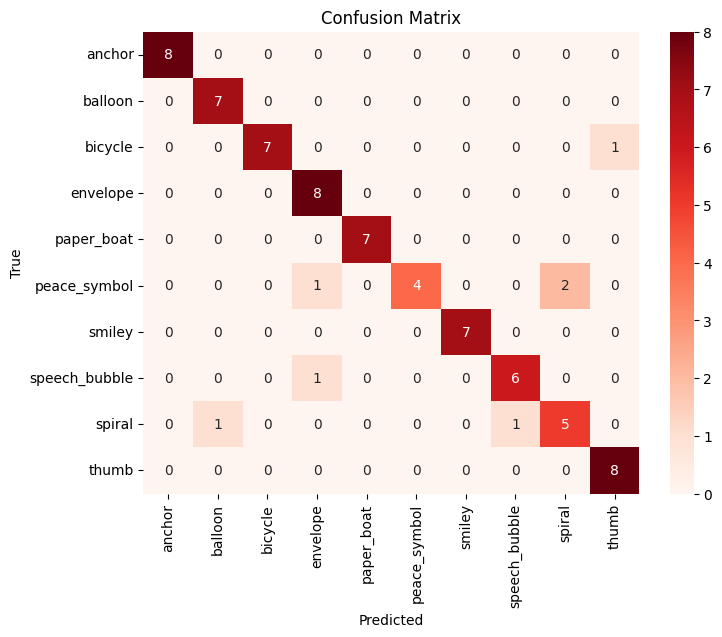

In [22]:
model.load_state_dict(torch.load('NajlepszyPytroch.pth'))

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_ds.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Slabo rozponaje znak pokoju (co może świadczyć o jego konserwatywnych poglądach #joke) i ze spiralą, czyli w sumie nie radzi sobie z okrągłymi krztałtami tak dobrze 